# <center> Credit Risks Using KNN and Random Forest  Classifiers </center> 
#### Expected Output
By the end of this mini project, you are supposed to deliver within your code:
Multiple accuracy measures resembling different k-neighbors used for training your KNN classifier.
One printed confusion matrix for the best model

In [429]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [431]:
from sklearn.datasets import fetch_openml
data = fetch_openml("credit-g", version=1)   #Get dataset from OpenML
df = data.frame  # Convert to Pandas DataFrame
df.head(2)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad


In [433]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   int64   
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   int64   
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   int64   
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   int64   
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   int64   
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [439]:
#making a subset of the datset by dropping irrelevant columns
df =df[['credit_history', 'credit_amount', 'installment_commitment', 'property_magnitude', 'age', 'housing', 'existing_credits', 'job', 'num_dependents', 'class']]
df.head(2)

,credit_history,credit_amount,installment_commitment,property_magnitude,age,housing,existing_credits,job,num_dependents,class
0,critical/other existing credit,1169,4,real estate,67,own,2,skilled,1,good
1,existing paid,5951,2,real estate,22,own,1,skilled,1,bad


### Visualization

Text(0.5, 1.0, 'Credit Amount vs Age')

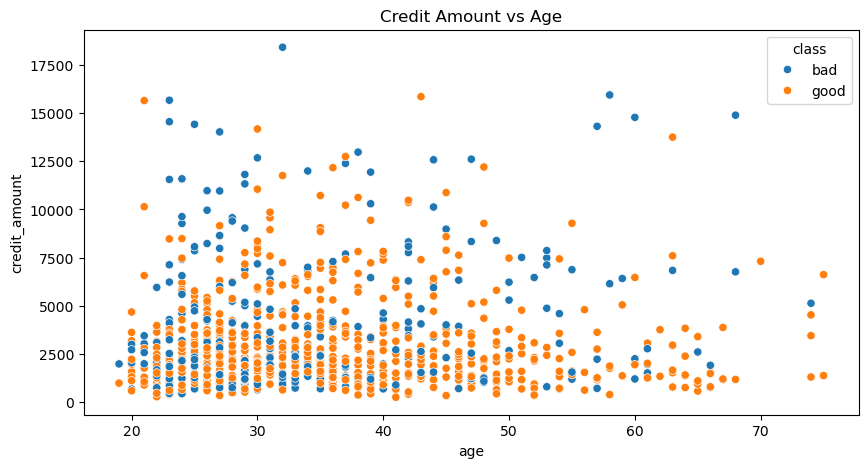

In [444]:
plt.figure(figsize=(10,5))
sns.scatterplot(data = df, x=df["age"], y=df["credit_amount"], hue=df["class"])
plt.title("Credit Amount vs Age")

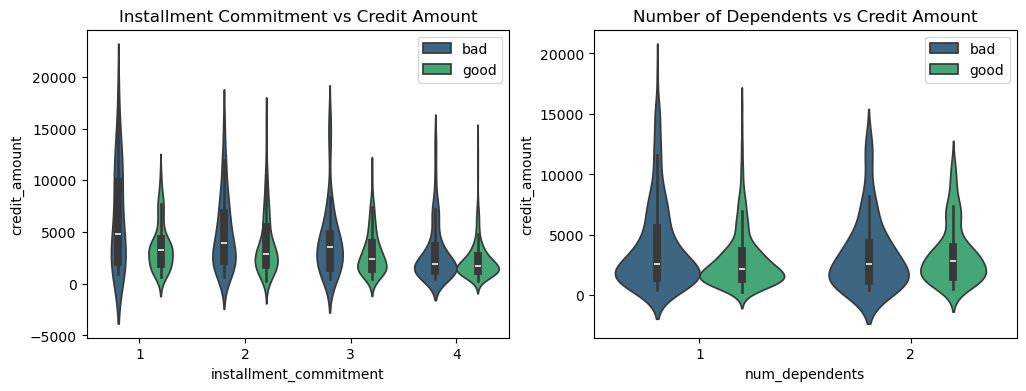

In [446]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  #1row, 2 columns barplot side by side

#For the first plot
sns.violinplot(ax=axs[0], x="installment_commitment", y="credit_amount", hue="class", data=df, palette="viridis")
axs[0].set_title("Installment Commitment vs Credit Amount")
axs[0].legend(loc="upper right")

#Second plot
sns.violinplot(ax=axs[1], x="num_dependents", y="credit_amount", hue="class", data=df, palette="viridis")
axs[1].set_title("Number of Dependents vs Credit Amount")
axs[1].legend(loc="upper right")


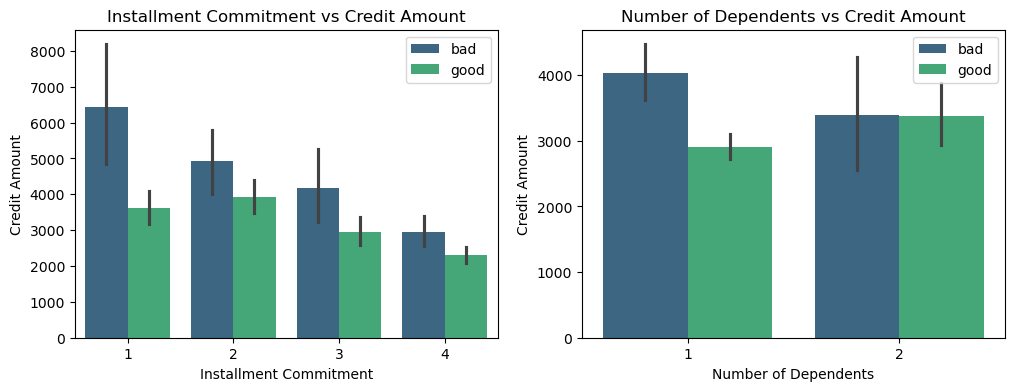

In [448]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  #1row, 2 columns barplot side by side
#For the first plot
sns.barplot(ax=axs[0], x="installment_commitment", y="credit_amount", hue="class", data=df, palette="viridis")
axs[0].set_title("Installment Commitment vs Credit Amount")
axs[0].set_xlabel("Installment Commitment")
axs[0].set_ylabel("Credit Amount")
axs[0].legend(loc="upper right")

#Second plot
sns.barplot(ax=axs[1], x="num_dependents", y="credit_amount", hue="class", data=df, palette="viridis")
axs[1].set_title("Number of Dependents vs Credit Amount")
axs[1].set_xlabel("Number of Dependents")
axs[1].set_ylabel("Credit Amount")
axs[1].legend(loc="upper right")

[Text(0, 0, 'Unemp/Unskld Non_Res'),
 Text(1, 0, 'High_Qual/Self-emp'),
 Text(2, 0, 'Unskilled_Res'),
 Text(3, 0, 'Skilled')]

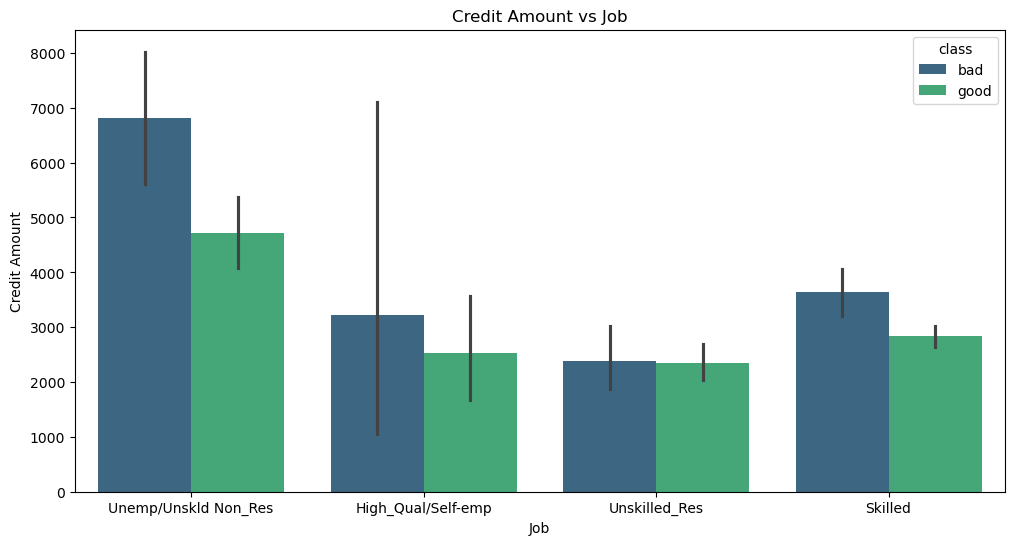

In [450]:
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(ax=axs, x="job", y="credit_amount", hue="class", data=df, palette="viridis")

# Titles and Labels
axs.set_title("Credit Amount vs Job")
axs.set_xlabel("Job")
axs.set_ylabel("Credit Amount")

new_labels = ['Unemp/Unskld Non_Res', 'High_Qual/Self-emp', 'Unskilled_Res', 'Skilled']  # Rename the labels
axs.set_xticklabels(new_labels)


In [452]:
print(df['job'].unique())  #displays unieque job categories column
print(df['job'].value_counts())

['skilled', 'unskilled resident', 'high qualif/self emp/mgmt', 'unemp/unskilled non res']
Categories (4, object): ['high qualif/self emp/mgmt', 'unemp/unskilled non res', 'unskilled resident', 'skilled']
job
skilled                      630
unskilled resident           200
high qualif/self emp/mgmt    148
unemp/unskilled non res       22
Name: count, dtype: int64


### Preprocessing

In [455]:
#Encoding data using OneHotEncoding
#### pd.get_dummies() quickly converts categorical data into numerical format
#### type=int saves memory and ensures values are stored as integers

from sklearn.preprocessing import OneHotEncoder
cat_columns = pd.get_dummies(df[['credit_history', 'property_magnitude', 'housing', 'job']], dtype=int) 
cat_columns.head(3)


,credit_history_all paid,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,property_magnitude_life insurance,property_magnitude_no known property,property_magnitude_real estate,property_magnitude_car,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_unemp/unskilled non res,job_unskilled resident,job_skilled
0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
2,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [457]:

num_columns = df[['credit_amount', 'installment_commitment', 'age', 'existing_credits', 'num_dependents']] #create variable name for numerical columns
num_columns.head(1)



,credit_amount,installment_commitment,age,existing_credits,num_dependents
0,1169,4,67,2,1


In [459]:
new_df = pd.concat([num_columns, cat_columns], axis=1)   #merge numerical and encoded categorical column
new_df.head(2)

,credit_amount,installment_commitment,age,existing_credits,num_dependents,credit_history_all paid,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,...,property_magnitude_no known property,property_magnitude_real estate,property_magnitude_car,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_unemp/unskilled non res,job_unskilled resident,job_skilled
0,1169,4,67,2,1,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1,5951,2,22,1,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1


In [461]:
#encode the label column 'class'
label_encoder = LabelEncoder()

# Assuming 'df' is your DataFrame and 'class' is the target column
df['class'] = label_encoder.fit_transform(df['class'])

In [463]:
# separating input features (X) from output labels (y).
X= new_df.iloc[:,:].values
y = df.iloc[:,-1].values

In [465]:
#SPlitting subset into 80% training set, 10% validation set and 10% test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)  #splits the .20 test_size into .50 i.e 10% of test size

print(f'Training set: {len(X_train)} sample of the dataset')
print(f'Test set: {len(X_test)} sample of the dataset')
print(f'Validation set: {len(X_val)} sample of the dataset')

Training set: 800 sample of the dataset
Test set: 100 sample of the dataset
Validation set: 100 sample of the dataset


In [467]:
#Scale split dataset, but only apply .fit to the train to avoid having misleading performance results
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


### Using KNN Classifier

In [470]:

modelKNC = KNeighborsClassifier(n_neighbors=5)
modelKNC.fit(X_train, y_train)
y_test_predKNC = modelKNC.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_predKNC)

y_val_predKNC = modelKNC.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_predKNC)


In [472]:
#Classification report for Test date and Val data to evaluate the model
print(classification_report(y_test, y_test_predKNC))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_predKNC))
print(f"\nValidation Accuracy: {val_accuracy:.2f}")


print(classification_report(y_val, y_val_predKNC))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_predKNC))

# Print Validation Accuracy

print(f"\nTest Accuracy: {test_accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.45      0.32      0.38        31
           1       0.73      0.83      0.78        69

    accuracy                           0.67       100
   macro avg       0.59      0.57      0.58       100
weighted avg       0.65      0.67      0.65       100


Confusion Matrix:
[[10 21]
 [12 57]]

Validation Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.36      0.18      0.24        28
           1       0.73      0.88      0.80        72

    accuracy                           0.68       100
   macro avg       0.54      0.53      0.52       100
weighted avg       0.63      0.68      0.64       100


Confusion Matrix:
[[ 5 23]
 [ 9 63]]

Test Accuracy: 0.67


### Optimize model using the best K

In [475]:

# Define range of K values
k_values = range(1, 10) 
accuracy = []
err_rate = []
accuracy_scores = {}  # Dictionary to store k values and their accuracy

best_k = None
best_score = 0

# Train and evaluate KNN for different values of K
for k in k_values:  
    modelKNC = KNeighborsClassifier(n_neighbors=k)
    modelKNC.fit(X_train, y_train)
    
    y_predKNC = modelKNC.predict(X_test)
    
    # Calculate accuracy and error rate
    acc = accuracy_score(y_test, y_predKNC) 
    error_rate = 1 - acc  # Error rate is just 1 - accuracy
    
    # Store values
    accuracy.append(acc)
    err_rate.append(error_rate)
    accuracy_scores[k] = acc  # Store accuracy in dictionary
    
    # Update best K if accuracy improves
    if acc > best_score:
        best_score = acc
        best_k = k

# Print best K and its accuracy
if best_k is not None:
    print(f"\nBest K: {best_k} with Accuracy: {best_score:.3f}")



Best K: 7 with Accuracy: 0.710


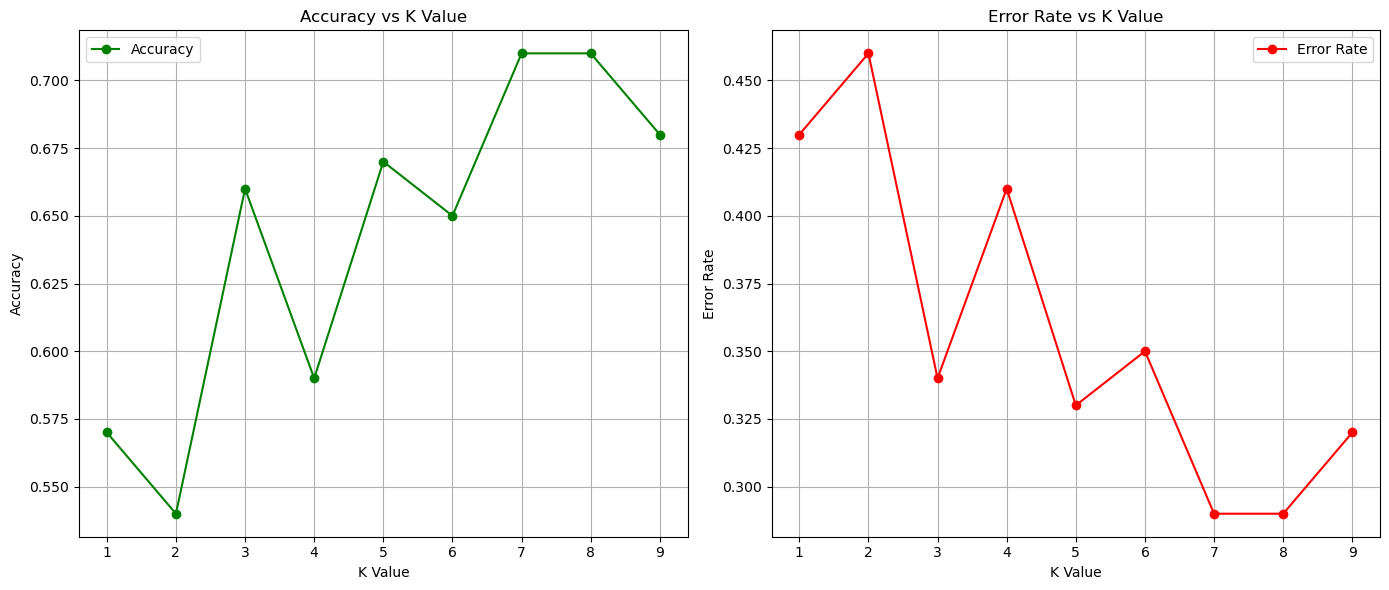

In [477]:
# Plot Accuracy and Error Rate as Subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Accuracy vs K
axs[0].plot(k_values, accuracy, color="green", marker="o", linestyle="-", label="Accuracy")
axs[0].set_title("Accuracy vs K Value")
axs[0].set_xlabel("K Value")
axs[0].set_ylabel("Accuracy")
axs[0].set_xticks(k_values)
axs[0].grid(True)
axs[0].legend()

# Plot Error Rate vs K
axs[1].plot(k_values, err_rate, color="red", marker="o", linestyle="-", label="Error Rate")
axs[1].set_title("Error Rate vs K Value")
axs[1].set_xlabel("K Value")
axs[1].set_ylabel("Error Rate")
axs[1].set_xticks(k_values)
axs[1].grid(True)
axs[1].legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

In [479]:
import numpy as np
err_rate=[]
err_rate.append(np.mean(y_best_pred !=y_test))
err_rate

[0.29]

In [481]:
# Train & evaluate KNN with the best k
best_knn_model = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train)
y_best_pred = best_knn_model.predict(X_test)
best_knn_model.score(X_test, y_test)

0.71

In [483]:
tn, fp, fn, tp = confusion_matrix(y_test, y_best_pred).ravel()
print("True Positives:",tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 62
True Negatives: 9
False Positives: 22
False Negatives: 7


Text(0.5, 1.0, 'Credit Risk')

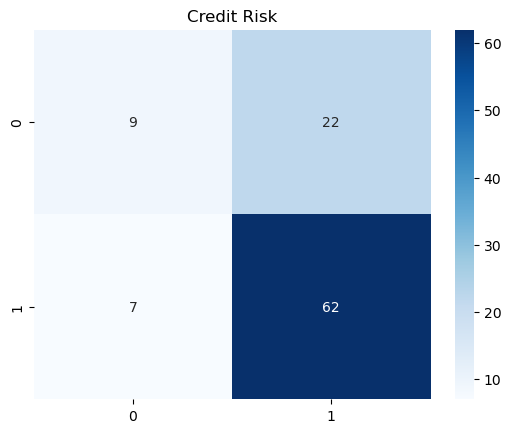

In [485]:
sns.heatmap(confusion_matrix(y_test, y_best_pred), annot = True, cmap='Blues').set_title("Credit Risk")

### Using Random Forest

In [488]:
modelRF = RandomForestClassifier(n_estimators = 10, bootstrap = True)
modelRF.fit(X_train, y_train)
y_predRF = modelRF.predict(X_test)
accuracyRF = accuracy_score(y_test, y_predRF)
con_matrixRF= confusion_matrix(y_test, y_predRF)

print('Random Forest Accuracy:', accuracyRF) 
print('Random Forest Matrix:\n', con_matrixRF) 
print(classification_report(y_test, y_predRF))

Random Forest Accuracy: 0.65
Random Forest Matrix:
 [[12 19]
 [16 53]]
              precision    recall  f1-score   support

           0       0.43      0.39      0.41        31
           1       0.74      0.77      0.75        69

    accuracy                           0.65       100
   macro avg       0.58      0.58      0.58       100
weighted avg       0.64      0.65      0.64       100



##### KNN model with K = 7 has got the best accuracy score 0.71, so it is the chosen model.

### Visualize Data
Since we scaled the entire dataset at once, we need to unscale the datapoints that ended up in our 'test data' if we want to visualize the results in their original feature space:

In [492]:
#At the moment, X_test_scaled is scaled
X_test

array([[ 1.34388588,  0.03119565, -0.04899402, ..., -0.14734777,
        -0.48038446, -1.30838236],
       [-0.63204052,  0.03119565, -0.31204916, ..., -0.14734777,
        -0.48038446,  0.76430257],
       [-1.0107914 ,  0.92249983, -1.01352954, ..., -0.14734777,
        -0.48038446,  0.76430257],
       ...,
       [ 1.29762096,  0.03119565,  1.52933683, ..., -0.14734777,
        -0.48038446,  0.76430257],
       [ 0.77144381, -0.86010854, -1.01352954, ..., -0.14734777,
        -0.48038446,  0.76430257],
       [-0.90307009,  0.03119565, -0.66278935, ..., -0.14734777,
         2.081666  , -1.30838236]])

In [494]:
# Undo a scaling operation using inverse_transform() method
X_test_orig = scaler.inverse_transform(X_test)

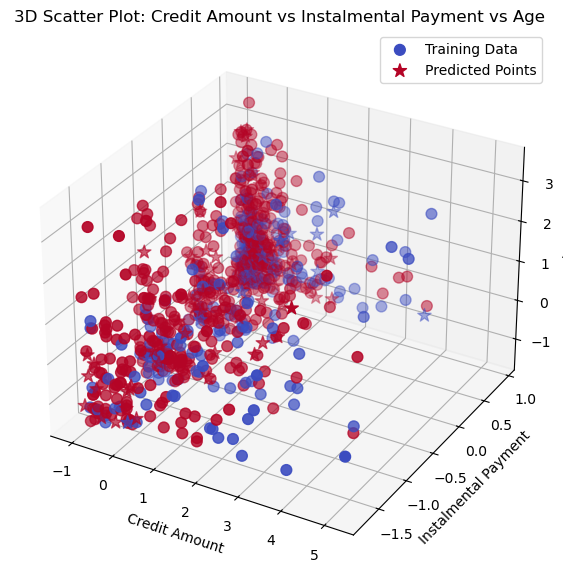

In [496]:
from mpl_toolkits.mplot3d import Axes3D  

# Make predictions on test set
y_best_pred = best_model.predict(X_test) # Ensure predictions has the same length as X_test

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the TRAINING dataset
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], 
           c=y_train, cmap="coolwarm", s=60, label="Training Data")

# Scatter plot for TEST dataset (predicted values)
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], 
           c=y_best_pred, cmap="coolwarm", marker="*", s=100, label="Predicted Points")

# Labels and title
ax.set_xlabel("Credit Amount")
ax.set_ylabel("Instalmental Payment")
ax.set_zlabel("Age")
ax.set_title("3D Scatter Plot: Credit Amount vs Instalmental Payment vs Age")

plt.legend()
plt.show()

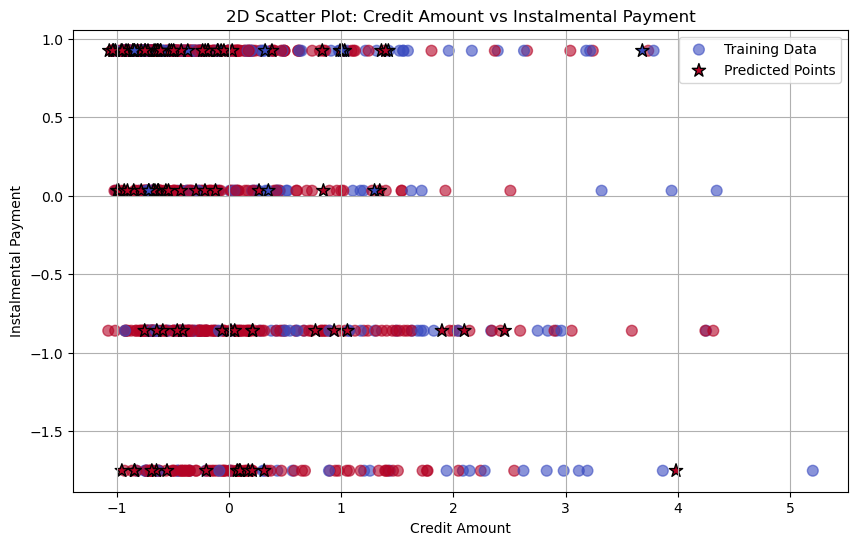

In [498]:

# Select two features for the 2D plot
feature_x = X_train[:, 0]  # Example: Credit Amount
feature_y = X_train[:, 1]  # Example: Instalmental Payment

# Select test data features
feature_x_test = X_test[:, 0]
feature_y_test = X_test[:, 1]

# Create a 2D scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot for TRAINING dataset
plt.scatter(feature_x, feature_y, c=y_train, cmap="coolwarm", s=60, label="Training Data", alpha=0.6)

# Scatter plot for TEST dataset (predicted values)
plt.scatter(feature_x_test, feature_y_test, c=y_best_pred, cmap="coolwarm", marker="*", s=100, label="Predicted Points", edgecolor="black")

# Labels and title
plt.xlabel("Credit Amount")
plt.ylabel("Instalmental Payment")
plt.title("2D Scatter Plot: Credit Amount vs Instalmental Payment")

# Show legend and plot
plt.legend()
plt.grid(True)
plt.show()